In [10]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nengo
import nengo_dl
from keras.utils import to_categorical

#sources:
#https://www.kaggle.com/code/vtu5118/cifar-10-using-vgg16
#https://towardsdatascience.com/creating-vgg-from-scratch-using-tensorflow-a998a5640155

In [2]:
vgg16_model = tf.keras.applications.vgg16.VGG16(weights='imagenet',
                    include_top=False,
                    classes=10,
                    input_shape=(32,32,3)# input: 32x32 images with 3 channels -> (32, 32, 3) tensors.
                   )

model = tf.keras.models.Sequential()

# Add vgg16 layers
for layer in vgg16_model.layers:
    model.add(layer)


# Fully connected layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu', name='hidden1'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(256, activation='relu', name='hidden2'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(10, activation='softmax', name='predictions'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)         2

(50000, 32, 32, 3)


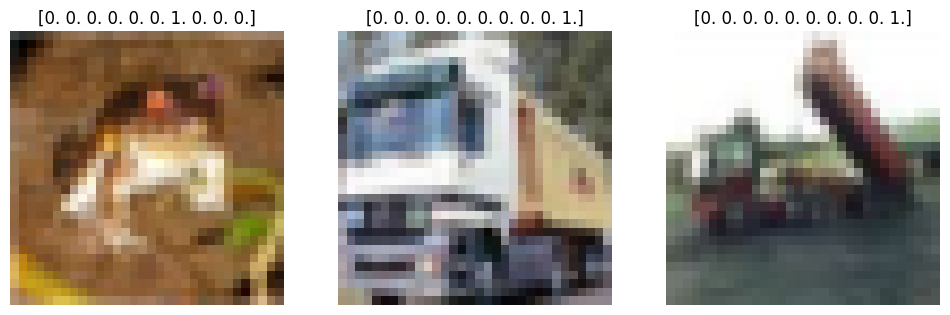

In [14]:
# Load CIFAR10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# One hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Data normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

In [4]:
# Shuffle data before splitting into validation set

p = np.random.permutation(len(x_train))
print(x_train.shape)
x_train, y_train = x_train[p], y_train[p]
print(x_train.shape)

# 20% validation, 80% training
val_split = 0.2
num_val = int(val_split * len(x_train))

# Split into train, validation, and test sets
x_val = x_train[:num_val]
y_val = y_train[:num_val]
print(x_val.shape)
print(y_val.shape)

x_train = x_train[num_val:]
y_train = y_train[num_val:]
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 10)
(40000, 32, 32, 3)
(40000, 10)


In [5]:
# For saving model weights
checkpoint_path = "training/vgg16.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [26]:
# Train model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
batch_size = 128
epochs = 100

model.compile(
    optimizer=optimizer,
    # optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy'
    ]
)

def lr_scheduler(epoch):
    return 0.001 * (0.5 ** (epoch // 20))

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# model.fit(aug.flow(x_train,y_train, batch_size=batch_size),
#           batch_size=batch_size,
#           epochs=epochs,
#           callbacks=[reduce_lr, cp_callback],
#           validation_data=(x_val, y_val))

In [7]:
model.load_weights(checkpoint_path)

loss, acc = model.evaluate(x_test, y_test)
print("Test Acc: {:5.2f}%, Test Loss: {:5.2f}".format(100 * acc, loss))

313/313 [==============================] - 20s 63ms/step - loss: 0.4016 - accuracy: 0.8821
Test Acc: 88.21%, Test Loss:  0.40


In [21]:
# Add time dimension to data for SNN
def add_time_dimension(arr):
    return np.reshape(arr, (arr.shape[0], 1, -1))

X_train_t = add_time_dimension(x_train)
Y_train_t = add_time_dimension(y_train)
X_val_t = add_time_dimension(x_val)
Y_val_t = add_time_dimension(y_val)
X_test_t = add_time_dimension(x_test)
Y_test_t = add_time_dimension(y_test)

print(X_train_t.shape)

ValueError: cannot reshape array of size 153600000 into shape (50000,1,32,32)

In [22]:
# Begin SNN conversion
ndl_model = nengo_dl.Converter(
    model,
    swap_activations={
        tf.keras.activations.relu: nengo.SpikingRectifiedLinear()
    },
    scale_firing_rates=20,
    synapse=0.005,
    inference_only=True
)

# Train model
# with nengo_dl.Simulator(converter.net, minibatch_size=batch_size) as sim:
#     # run training
#     sim.compile(
#         optimizer=optimizer,
#         loss=tf.losses.CategoricalCrossentropy(from_logits=True),
#         metrics=[tf.metrics.sparse_categorical_accuracy],
#     )

#     converted_inp = converter.inputs[model.input]
#     converted_dense = converter.outputs[model.output]

#     sim.fit(
#         {converted_inp: X_train_t},
#         {converted_dense: Y_train_t},
#         validation_data=(
#             {converted_inp: X_val_t},
#             {converted_dense: Y_val_t}
#         ),
#         callbacks=[reduce_lr],
#         epochs=epochs
#     )

#     # save the parameters to file
#     sim.save_params("./training/keras_to_snn_params")

d:\Folders\Programming\snn-research\vgg16-snn\.env\lib\site-packages\nengo_dl\converter.py:920: UserWarning: Converting sequential model to functional model; use `Converter.model` to refer to the functional model (rather than the original sequential model) when working with the output of the Converter
  warnings.warn(
d:\Folders\Programming\snn-research\vgg16-snn\.env\lib\site-packages\nengo_dl\converter.py:324: UserWarning: Cannot convert max pooling layers to native Nengo objects; consider setting max_to_avg_pool=True to use average pooling instead. Falling back to TensorNode.
  warnings.warn(
d:\Folders\Programming\snn-research\vgg16-snn\.env\lib\site-packages\nengo_dl\converter.py:324: UserWarning: Layer type Dropout does not have a registered converter. Falling back to TensorNode.
  warnings.warn(
d:\Folders\Programming\snn-research\vgg16-snn\.env\lib\site-packages\nengo_dl\converter.py:583: UserWarning: Activation type <function softmax at 0x000002317FC37250> does not have a nati

In [28]:
# Source: https://r-gaurav.github.io/2021/03/07/Spiking-Neural-Nets-for-Image-Classification-in-Nengo-DL.html
# Tile the test images.
def get_nengo_compatible_test_data_generator(batch_size=100, n_steps=30):
  """
  Returns a test data generator of tiled (i.e. repeated) images.

  Args:
    batch_size <int>: Number of data elements in each batch.
    n_steps <int>: Number of timesteps for which the test data has to
                   be repeated.
  """
  num_images = x_test.shape[0]
  # Flatten the images
  reshaped_x_test = x_test.reshape((num_images, 1, -1))
  # Tile/Repeat them for `n_steps` times.
  tiled_x_test = np.tile(reshaped_x_test, (1, n_steps, 1))

  for i in range(0, num_images, batch_size):
    yield (tiled_x_test[i:i+batch_size], y_test[i:i+batch_size])

n_steps = 30 # Number of timesteps
collect_spikes_output = True
ndl_mdl_spikes = [] # To store the spike outputs of the first Conv layer and the
                    # penultimate dense layer whose probes we defined earlier.
ndl_mdl_otpt_cls_probs = [] # To store the true class labels and the temporal
                            # class-probabilities output of the model.

test_batches = get_nengo_compatible_test_data_generator(
    batch_size=batch_size, n_steps = n_steps)

ndl_mdl_inpt = ndl_model.inputs[model.input] # Input layer is Layer 0.
ndl_mdl_otpt = ndl_model.outputs[model.output] # Output layer is last.

# Run the simulation.
with nengo_dl.Simulator(ndl_model.net, minibatch_size=batch_size) as sim:
  # Predict on each batch.
  for batch in test_batches:
    sim_data = sim.predict_on_batch({ndl_mdl_inpt: batch[0]})
    for y_true, y_pred in zip(batch[1], sim_data[ndl_mdl_otpt]):
      # Note that y_true is an array of shape (10,) and y_pred is a matrix of
      # shape (n_steps, 10) where 10 is the number of classes in CIFAR-10 dataset.
      ndl_mdl_otpt_cls_probs.append((y_true, y_pred))

KeyError: (<Reference wrapping <KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'reshape')>>,)